In [1]:
import pandas as pd
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.impute import SimpleImputer

import numpy as np


In [2]:
path = "../train_data/"
data = pd.read_csv(path + "clear_data_times_data.csv", index_col=False)

In [3]:
data.head()

,Unnamed: 0,region,ua_device_type,ua_client_type,ua_os,ua_client_name,total_watchtime,rutube_video_id,viewer_uid,adjusted_time,title,category,duration,author_id,age,age_class,sex,date
0,0,Chelyabinsk,desktop,browser,Windows,Yandex Browser,1883,video_133074,10067243,08:40:58,Папа с особенностями. Мужское / Женское. Выпус...,Телепередачи,2456534,1009219,20,0,female,1
1,1,Bashkortostan Republic,smartphone,mobile app,Android,Rutube,512,video_362960,10245341,21:33:24,Comedy Club: Мальдивы | Андрей Бебуришвили,Юмор,519211,1006760,40,2,female,1
2,3,Moscow,smartphone,mobile app,Android,Rutube,1521,video_161610,10029092,23:03:42,Сергей Орлов-снял дом!!!,Разное,1522069,1058671,41,3,male,1
3,4,Moscow,smartphone,mobile app,Android,Rutube,71,video_116245,10452976,22:48:09,Ищем сокровища в Полевском | Уральская Флоренц...,Путешествия,1249920,1020020,38,2,female,1
4,5,Rostov,smartphone,mobile app,Android,Rutube,60,video_61152,10013813,04:11:51,День защиты детей. Мужское / Женское. Выпуск о...,Телепередачи,2465238,1009219,44,3,female,1


In [4]:
data.columns

Index(['Unnamed: 0', 'region', 'ua_device_type', 'ua_client_type', 'ua_os',
       'ua_client_name', 'total_watchtime', 'rutube_video_id', 'viewer_uid',
       'adjusted_time', 'title', 'category', 'duration', 'author_id', 'age',
       'age_class', 'sex', 'date'],
      dtype='object')

In [5]:
data = data.drop(columns=['Unnamed: 0'])

In [6]:
all_users = list(data['viewer_uid'].unique())

In [7]:
all_data = pd.read_csv(path + "all_events.csv")

In [8]:
import nltk
from nltk.corpus import stopwords
from natasha import Segmenter, MorphVocab, NewsEmbedding, NewsMorphTagger, Doc
from collections import Counter

nltk.download('stopwords')
russian_stopwords = set(stopwords.words('russian'))

# Инициализация инструментов Natasha
segmenter = Segmenter()
morph_vocab = MorphVocab()
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)

def preprocess_text(text):
    doc = Doc(text)
    doc.segment(segmenter)
    doc.tag_morph(morph_tagger)
    
    # Приведение к нормальной форме и фильтрация
    normalized_words = []
    for token in doc.tokens:
        if token.text.lower() not in russian_stopwords and token.pos == 'NOUN':  # Например, оставляем только существительные
            token.lemmatize(morph_vocab)
            normalized_words.append(token.lemma)
    return normalized_words

# Применяем обработку к каждому названию видео
data['cleaned_title'] = data['title'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to /Users/ivan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
from datetime import timedelta

timezone_offsets = {
    'Moscow': timedelta(hours=0),
    'Chelyabinsk': timedelta(hours=2),
    'Tatarstan Republic': timedelta(hours=0),
    'Bashkortostan Republic': timedelta(hours=2),
    'Novosibirsk Oblast': timedelta(hours=4),
    'Moscow Oblast': timedelta(hours=0),
    'Omsk Oblast': timedelta(hours=3),
    'Chuvashia': timedelta(hours=0),
    'Krasnoyarsk Krai': timedelta(hours=4),
    'Kamchatka': timedelta(hours=9),
    'Nizhny Novgorod Oblast': timedelta(hours=0),
    'Krasnodar Krai': timedelta(hours=0),
    'Volgograd Oblast': timedelta(hours=1),
    'Kaliningrad Oblast': timedelta(hours=-1),
    'Kuzbass': timedelta(hours=4),
    'Stavropol Kray': timedelta(hours=0),
    'Samara Oblast': timedelta(hours=1),
    'Amur Oblast': timedelta(hours=6),
    'Sverdlovsk Oblast': timedelta(hours=2),
    'St.-Petersburg': timedelta(hours=0),
    'Yamalo-Nenets': timedelta(hours=2),
    'Orenburg Oblast': timedelta(hours=2),
    'Khanty-Mansia': timedelta(hours=2),
    'Kaluga Oblast': timedelta(hours=0),
    'Tomsk Oblast': timedelta(hours=4),
    'Novgorod Oblast': timedelta(hours=0),
    'Arkhangelskaya': timedelta(hours=0),
    'North Ossetia–Alania': timedelta(hours=0),
    'Kursk Oblast': timedelta(hours=0),
    'Leningradskaya Oblast': timedelta(hours=0),
    'Krasnoyarskiy': timedelta(hours=4),
    'Ivanovo Oblast': timedelta(hours=0),
    'Altay Kray': timedelta(hours=4),
    'Kurgan Oblast': timedelta(hours=2),
    'Kostroma Oblast': timedelta(hours=0),
    'Bryansk Oblast': timedelta(hours=0),
    'Dagestan': timedelta(hours=0),
    'Lipetsk Oblast': timedelta(hours=0),
    'Vladimir Oblast': timedelta(hours=0),
    'Kirov Oblast': timedelta(hours=0),
    'Khabarovsk': timedelta(hours=7),
    'Tambov Oblast': timedelta(hours=0),
    'Chukotka': timedelta(hours=9),
    'Voronezh Oblast': timedelta(hours=0),
    'Sverdlovsk': timedelta(hours=2),
    'Tula Oblast': timedelta(hours=0),
    'Krasnodarskiy': timedelta(hours=0),
    'Irkutsk Oblast': timedelta(hours=5),
    'Saratov Oblast': timedelta(hours=1),
    'Khakasiya Republic': timedelta(hours=4),
    'Penza': timedelta(hours=0),
    'Perm Krai': timedelta(hours=2),
    'Oryol oblast': timedelta(hours=0),
    'Vladimir': timedelta(hours=0),
    'Smolensk Oblast': timedelta(hours=0),
    'Penza Oblast': timedelta(hours=0),
    'Mordoviya Republic': timedelta(hours=0),
    'Tyumen’ Oblast': timedelta(hours=2),
    'Sakha': timedelta(hours=6),
    'Primorye': timedelta(hours=7),
    'Zabaykalskiy (Transbaikal) Kray': timedelta(hours=6),
    'Vologda Oblast': timedelta(hours=0),
    'Yaroslavl Oblast': timedelta(hours=0),
    'Crimea': timedelta(hours=0),
    'Rostov': timedelta(hours=0),
    'Ryazan Oblast': timedelta(hours=0),
    'Perm': timedelta(hours=2),
    'Chechnya': timedelta(hours=0),
    'Udmurtiya Republic': timedelta(hours=1),
    'Tver Oblast': timedelta(hours=0),
    'Buryatiya Republic': timedelta(hours=5),
    'Belgorod Oblast': timedelta(hours=0),
    'Kaluga': timedelta(hours=0),
    'Astrakhan Oblast': timedelta(hours=1),
    'Karelia': timedelta(hours=0),
    'Murmansk': timedelta(hours=0),
    'Adygeya Republic': timedelta(hours=0),
    'Kemerovo Oblast': timedelta(hours=4),
    'Mariy-El Republic': timedelta(hours=0),
    'Kursk': timedelta(hours=0),
    'Saratovskaya Oblast': timedelta(hours=1),
    'Sakhalin Oblast': timedelta(hours=8),
    'Ivanovo': timedelta(hours=0),
    'Tyumen Oblast': timedelta(hours=2),
    'Stavropol’ Kray': timedelta(hours=0),
    'Voronezj': timedelta(hours=0),
    'Karachayevo-Cherkesiya Republic': timedelta(hours=0),
    'Kabardino-Balkariya Republic': timedelta(hours=0),
    'Ulyanovsk': timedelta(hours=1),
    'North Ossetia': timedelta(hours=0),
    'Komi': timedelta(hours=0),
    'Smolensk': timedelta(hours=0),
    'Tver’ Oblast': timedelta(hours=0),
    'Sebastopol City': timedelta(hours=0),
    'Pskov Oblast': timedelta(hours=0),
    'Tula': timedelta(hours=0),
    'Orel Oblast': timedelta(hours=0),
    'Jaroslavl': timedelta(hours=0),
    'Tambov': timedelta(hours=0),

    'Kalmykiya Republic': timedelta(hours=0),
    'Primorskiy (Maritime) Kray': timedelta(hours=7),
    'Altai': timedelta(hours=4),
    'Magadan Oblast': timedelta(hours=8),
    'Vologda': timedelta(hours=0),
    'Tyva Republic': timedelta(hours=4),
    'Nenets': timedelta(hours=0),
    'Smolenskaya Oblast’': timedelta(hours=0),
    'Jewish Autonomous Oblast': timedelta(hours=7),
    'Astrakhan': timedelta(hours=1),
    'Ingushetiya Republic': timedelta(hours=0),
    'Kirov': timedelta(hours=0),
    'Transbaikal Territory': timedelta(hours=5),
    'Omsk': timedelta(hours=3),
    'Kaliningrad': timedelta(hours=-1),
    'Stavropol Krai': timedelta(hours=0),
    'Arkhangelsk Oblast': timedelta(hours=0)
}

In [10]:
# Объединяем все названия видео для каждого пользователя и вычисляем топ-5 слов
user_titles = data.groupby('viewer_uid')['cleaned_title'].apply(lambda x: [word for sublist in x for word in sublist]).reset_index()

def most_common_words(words_list):
    counter = Counter(words_list)
    return [word for word, _ in counter.most_common(5)]

user_titles['top_5_words'] = user_titles['cleaned_title'].apply(most_common_words)
for i in range(5):
    user_titles[f'top_word_{i+1}'] = user_titles['top_5_words'].apply(lambda x: x[i] if len(x) > i else 'none')

In [24]:
# Среднее время просмотра на пользователя
user_watchtime = data.groupby('viewer_uid')['total_watchtime'].mean().reset_index()
user_watchtime.columns = ['viewer_uid', 'avg_watchtime']

# Общее количество просмотров для каждого пользователя
total_views = data.groupby('viewer_uid')['rutube_video_id'].count().reset_index()
total_views.columns = ['viewer_uid', 'total_views']

# Количество уникальных видео для каждого пользователя
unique_videos = data.groupby('viewer_uid')['rutube_video_id'].nunique().reset_index()
unique_videos.columns = ['viewer_uid', 'unique_videos']

# Средняя длительность видео
avg_video_duration = data.groupby('viewer_uid')['duration'].mean().reset_index()
avg_video_duration.columns = ['viewer_uid', 'avg_video_duration']

# Частота категорий видео
top_category = data.groupby('viewer_uid')['category'].agg(lambda x: x.mode()[0]).reset_index()
top_category.columns = ['viewer_uid', 'top_category']

data['adjusted_time'] = pd.to_datetime(data['adjusted_time'])

# Извлечение часа из времени просмотра
data['hour'] = data['adjusted_time'].dt.hour

# Категоризация времени на части дня
def get_time_of_day(hour):
    if 5 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 17:
        return 'afternoon'
    elif 17 <= hour < 21:
        return 'evening'
    else:
        return 'night'
    
def calculate_weekday(day):
    # 1 июля - это суббота, номер дня в неделе для субботы - 5 (0 - понедельник, 6 - воскресенье)
    # Используем модульное деление для определения дня недели
    start_day_of_week = 5  # Суббота
    return (start_day_of_week + (day - 1)) % 7

data['time_of_day'] = data['hour'].apply(get_time_of_day)

most_cummon_time_of_day = data.groupby('viewer_uid')['time_of_day'].agg(lambda x: x.mode()[0]).reset_index()
most_cummon_time_of_day.columns = ['viewer_uid', 'most_cummon_time_of_day']

data['weekday'] = data['date'].apply(calculate_weekday)
data['is_weekend'] = data['weekday'].apply(lambda x: 1 if x >= 5 else 0)

# День недели, в который чаще всего смотрят видео
most_common_weekday = data.groupby('viewer_uid')['weekday'].agg(lambda x: x.mode()[0]).reset_index()
most_common_weekday.columns = ['viewer_uid', 'most_common_weekday']

# Среднее количество просмотров одного и того же автора для каждого пользователя
author_views = data.groupby(['viewer_uid', 'author_id'])['rutube_video_id'].count().reset_index()
author_views.columns = ['viewer_uid', 'author_id', 'views_per_author']
avg_views_per_author = author_views.groupby('viewer_uid')['views_per_author'].mean().reset_index()
avg_views_per_author.columns = ['viewer_uid', 'avg_views_per_author']

# Получаем 3 самых популярных авторов для каждого пользователя
def top_authors(series):
    top_authors_list = series.value_counts().nlargest(3).index.tolist()
    # Если авторов меньше 3, заполняем NaN
    return top_authors_list + [None] * (3 - len(top_authors_list))

top_authors = data.groupby('viewer_uid')['author_id'].agg(top_authors).reset_index()

# Преобразуем список из 3 авторов в 3 отдельных столбца
top_authors[['top_author_1', 'top_author_2', 'top_author_3']] = pd.DataFrame(top_authors['author_id'].tolist(), index=top_authors.index)

# Убираем исходный столбец со списком авторов
top_authors = top_authors.drop(columns=['author_id'])

# Концентрация по категориям
category_concentration = data.groupby('viewer_uid')['category'].agg(lambda x: x.value_counts(normalize=True).max()).reset_index()
category_concentration.columns = ['viewer_uid', 'category_concentration']

# Разница во времени между просмотрами для каждого пользователя
data['watch_time_diff'] = data.groupby('viewer_uid')['adjusted_time'].diff().dt.total_seconds()
avg_time_between_views = data.groupby('viewer_uid')['watch_time_diff'].mean().reset_index()
avg_time_between_views.columns = ['viewer_uid', 'avg_time_between_views']

# Доля просмотров в выходные для каждого пользователя
weekend_views_ratio = data.groupby('viewer_uid')['is_weekend'].mean().reset_index()
weekend_views_ratio.columns = ['viewer_uid', 'weekend_views_ratio']

# Объединение всех признаков в одну таблицу
features = data[['viewer_uid', 'region', 'ua_device_type', 'ua_client_type', 'ua_os', 'ua_client_name']].drop_duplicates(subset=['viewer_uid'])

features = features.merge(user_watchtime, on='viewer_uid', how='left')
features = features.merge(avg_video_duration, on='viewer_uid', how='left')
features = features.merge(top_category, on='viewer_uid', how='left')
features = features.merge(category_concentration, on='viewer_uid', how='left')
features = features.merge(most_cummon_time_of_day, on='viewer_uid', how='left')
features = features.merge(most_common_weekday, on='viewer_uid', how='left')
features = features.merge(avg_views_per_author, on='viewer_uid', how='left')
features = features.merge(top_authors, on='viewer_uid', how='left')
features = features.merge(avg_time_between_views, on='viewer_uid', how='left')
features = features.merge(weekend_views_ratio, on='viewer_uid', how='left')
features = features.merge(total_views, on='viewer_uid', how='left')
features = features.merge(user_titles[['viewer_uid', 'top_word_1', 'top_word_2', 'top_word_3', 'top_word_4', 'top_word_5']], on='viewer_uid', how='left')

features['rel_watchtime'] = features['avg_watchtime'] / features['avg_video_duration']
features = features.drop(columns=['avg_watchtime', 'ua_client_type', 'avg_video_duration'])

# Добавляем пол
features = features.merge(data[['viewer_uid', 'sex', 'age_class']].drop_duplicates(subset=['viewer_uid']), on='viewer_uid', how='left')

# Заполнение пропусков
imputer = SimpleImputer(strategy='most_frequent')
features = pd.DataFrame(imputer.fit_transform(features), columns=features.columns)

for col in ['top_author_1', 'top_author_2', 'top_author_3']:
    features[col] = features[col].apply(int).astype(int)

cat_features = ['region', 'ua_device_type', 'ua_os', 'ua_client_name', 'top_category', 'most_cummon_time_of_day', 'most_common_weekday',
                'top_author_1', 'top_author_2', 'top_author_3', 'top_word_1', 'top_word_2', 'top_word_3', 'top_word_4', 'top_word_5']
        
    

In [25]:
for col in cat_features:
    features[col] = features[col].astype(str)
    

X = features.drop(columns=['sex', 'age_class'])

y1 = features['sex']
y2 = features['age_class']

sex_decode = {"female": 0, "male": 1}
sex_encode = {0: "female", 1: "male"}

y1 = y1.apply(lambda x: sex_decode[x])

In [26]:
X.shape

(148931, 22)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X.drop(columns=["viewer_uid"]), y1, test_size=0.2, random_state=42, stratify=y1)

In [28]:
X_train.head(1)

,region,ua_device_type,ua_os,ua_client_name,top_category,category_concentration,most_cummon_time_of_day,most_common_weekday,avg_views_per_author,top_author_1,...,top_author_3,avg_time_between_views,weekend_views_ratio,total_views,top_word_1,top_word_2,top_word_3,top_word_4,top_word_5,rel_watchtime
76237,Moscow Oblast,smartphone,Android,Firefox Mobile,Видеоигры,1.0,morning,6,1.0,1018241,...,1002256,-76.0,1.0,1,none,none,none,none,none,0.002743


In [29]:
param_grid = {
    'iterations': [100, 250, 500],
    'learning_rate': [0.01, 0.1],
    'depth': [4, 8]
}

grid_search = GridSearchCV(estimator=CatBoostClassifier(random_state=42, verbose=0,
                                                        cat_features=cat_features),
                           param_grid=param_grid, cv=5, verbose=0)

grid_search.fit(X_train, y_train)
best_catboost_model = grid_search.best_estimator_

In [30]:
from sklearn.metrics import accuracy_score

y1_pred = best_catboost_model.predict(X_test)
accuracy = accuracy_score(y_test, y1_pred)
print(f'Acc sex of CatBoost: {accuracy:.2f}')

Acc sex of CatBoost: 0.74


In [31]:
X.head()

,viewer_uid,region,ua_device_type,ua_os,ua_client_name,top_category,category_concentration,most_cummon_time_of_day,most_common_weekday,avg_views_per_author,...,top_author_3,avg_time_between_views,weekend_views_ratio,total_views,top_word_1,top_word_2,top_word_3,top_word_4,top_word_5,rel_watchtime
0,10067243,Chelyabinsk,desktop,Windows,Yandex Browser,Телепередачи,0.972973,afternoon,6,6.166667,...,1002137,145.888889,0.378378,37,выпуск,свадьба,врач,сезон,стиль,0.000765
1,10245341,Bashkortostan Republic,smartphone,Android,Rutube,Телепередачи,0.708333,morning,1,6.857143,...,1006760,-275.170213,0.25,48,выпуск,сезон,богиня,свидание,шопинг,0.000741
2,10029092,Moscow,smartphone,Android,Rutube,Разное,0.5,night,2,1.428571,...,1016312,-8387.111111,0.3,10,дом,бабка,дача,история,юрист,0.000968
3,10452976,Moscow,smartphone,Android,Rutube,Телепередачи,0.666667,night,2,1.285714,...,1002256,163.875,0.444444,9,выпуск,поиск,сезон,сокровище,отпуск,0.000446
4,10013813,Rostov,smartphone,Android,Rutube,Телепередачи,0.973684,morning,5,12.666667,...,1006312,519.573333,0.289474,76,выпуск,год,днк,июнь,мать,0.000739


In [32]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148931 entries, 0 to 148930
Data columns (total 24 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   viewer_uid               148931 non-null  object
 1   region                   148931 non-null  object
 2   ua_device_type           148931 non-null  object
 3   ua_os                    148931 non-null  object
 4   ua_client_name           148931 non-null  object
 5   top_category             148931 non-null  object
 6   category_concentration   148931 non-null  object
 7   most_cummon_time_of_day  148931 non-null  object
 8   most_common_weekday      148931 non-null  object
 9   avg_views_per_author     148931 non-null  object
 10  top_author_1             148931 non-null  object
 11  top_author_2             148931 non-null  object
 12  top_author_3             148931 non-null  object
 13  avg_time_between_views   148931 non-null  object
 14  weekend_views_ratio 

In [33]:
X_train_age, X_test_age, y_train_age, y_test_age = train_test_split(X.drop(columns=['viewer_uid']), y2, test_size=0.2, random_state=42, stratify=y2)

In [34]:
classes_age = np.unique(y_train_age)
weights_age = compute_class_weight(class_weight='balanced', classes=classes_age, y=y_train_age)
class_weights_age = dict(zip(classes_age, weights_age))

In [35]:
class_weights_age

{0: 6.476625353337682,
 1: 0.7504093920842466,
 2: 0.6820388349514563,
 3: 0.9552918537524054}

In [36]:
param_grid = {
    'iterations': [100, 250],
    'learning_rate': [0.01, 0.1],
    'depth': [4, 10]
}

grid_search = GridSearchCV(estimator=CatBoostClassifier(random_state=42, verbose=0,
                                                        cat_features=cat_features,
                                                        class_weights=class_weights_age),
                           param_grid=param_grid, cv=5, verbose=0)

grid_search.fit(X_train_age, y_train_age)
best_catboost_model_age = grid_search.best_estimator_

In [37]:
y2_pred = best_catboost_model_age.predict(X_test_age)

In [38]:
y2_pred = [i[0] for i in y2_pred]

In [39]:
y_test_age = y_test_age.to_list()

In [40]:
f1 = f1_score(y_test_age, y2_pred, average='weighted')
print(f'F1 age of CatBoost: {f1:.2f}')

F1 age of CatBoost: 0.42


In [41]:
final_score = 0.7 * f1 + 0.3 * accuracy
print("Finall: ", final_score)

Finall:  0.5169615236658995


In [42]:
X.shape

(148931, 22)

In [43]:
data.shape

(1258601, 23)

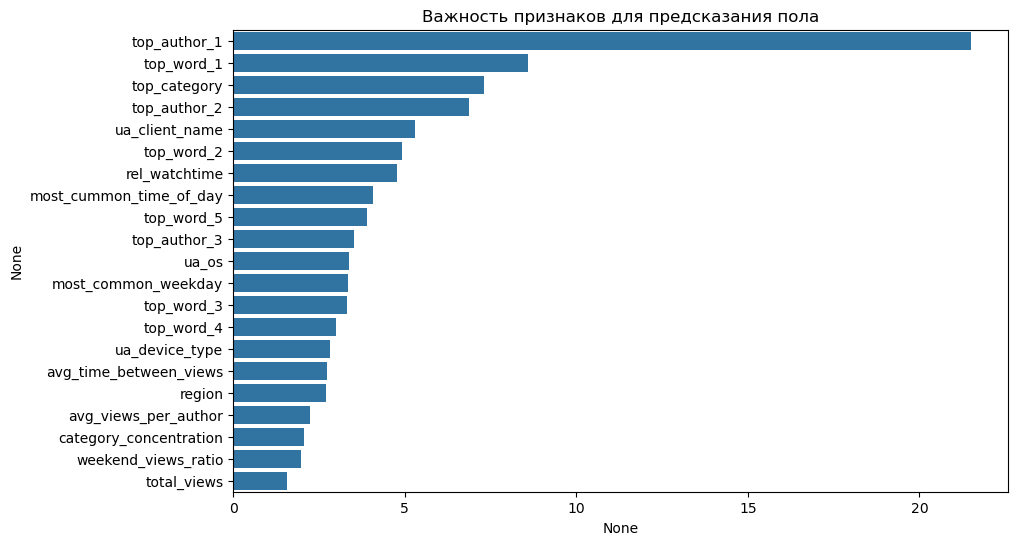

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

# Важность признаков
importances = best_catboost_model.feature_importances_
feature_names = X_train.columns
feature_importance = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# Визуализация важности признаков
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance, y=feature_importance.index)
plt.title('Важность признаков для предсказания пола')
plt.show()

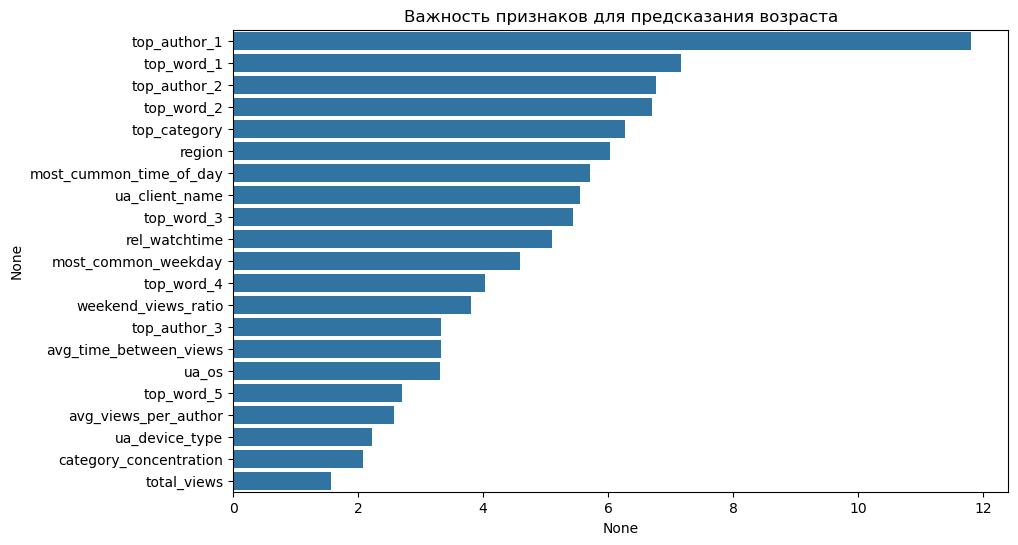

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

# Важность признаков
importances = best_catboost_model_age.feature_importances_
feature_names = X_train_age.columns
feature_importance = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# Визуализация важности признаков
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance, y=feature_importance.index)
plt.title('Важность признаков для предсказания возраста')
plt.show()

# Исследуем зависимость от минимально истории пользователя

In [46]:
X_test['sex'] = y_test
X_test_age['age'] = y_test_age

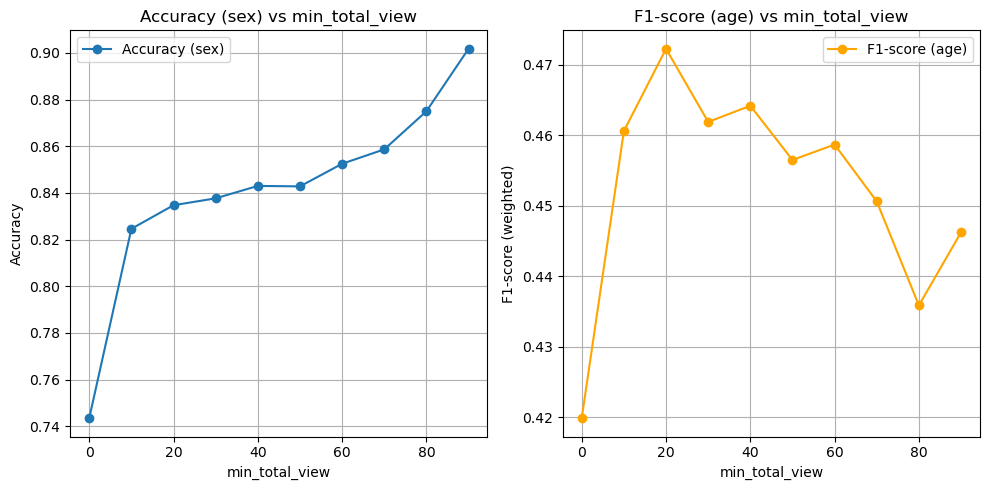

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score

# Списки для хранения результатов
accuracy_scores = []
f1_scores = []

# Определяем диапазон значений min_total_view
min_total_view_values = np.arange(0, 100, 10)  # например, от 0 до 100 с шагом 10

# Цикл по значениям min_total_view
for min_total_view in min_total_view_values:
    # Фильтруем тестовые датасеты
    X_test_filtered = X_test[X_test['total_views'] >= min_total_view]
    X_test_age_filtered = X_test_age[X_test_age['total_views'] >= min_total_view]
    
    # Проверяем, что после фильтрации остались данные
    if len(X_test_filtered) > 0 and len(X_test_age_filtered) > 0:
        y_test_filtered = X_test_filtered['sex']
        y_test_age_filtered = X_test_age_filtered['age']
        
        # Предсказания моделей
        y_pred_sex = best_catboost_model.predict(X_test_filtered.drop('sex', axis=1))
        y_pred_age = best_catboost_model_age.predict(X_test_age_filtered.drop('age', axis=1))
        
        # Вычисление метрик
        accuracy = accuracy_score(y_test_filtered, y_pred_sex)
        f1 = f1_score(y_test_age_filtered, y_pred_age, average='weighted')
        
        # Сохраняем результаты
        accuracy_scores.append(accuracy)
        f1_scores.append(f1)
    else:
        accuracy_scores.append(None)
        f1_scores.append(None)

# Построение графиков
plt.figure(figsize=(10, 5))

# График точности
plt.subplot(1, 2, 1)
plt.plot(min_total_view_values, accuracy_scores, marker='o', label='Accuracy (sex)')
plt.xlabel('min_total_view')
plt.ylabel('Accuracy')
plt.title('Accuracy (sex) vs min_total_view')
plt.grid(True)
plt.legend()

# График F1-score
plt.subplot(1, 2, 2)
plt.plot(min_total_view_values, f1_scores, marker='o', label='F1-score (age)', color='orange')
plt.xlabel('min_total_view')
plt.ylabel('F1-score (weighted)')
plt.title('F1-score (age) vs min_total_view')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [49]:
# Сохранение модели пола
best_catboost_model.save_model('../best_catboost_model_sex.cbm')

# Сохранение модели возраста
best_catboost_model_age.save_model('../best_catboost_model_age.cbm')